In [1]:
import numpy as np
from numpy.random import choice
from scipy.interpolate import griddata

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 18

np.random.seed(42)

In [2]:
def plot_optimization(X, Y, F, ps, fs, colors, figsize=(16, 6)):
    fig = plt.figure(figsize=figsize)
    axs = [
        fig.add_subplot(1, 2, 1, projection='3d'),
        fig.add_subplot(1, 2, 2)
    ]
    axs[0].plot_surface(X, Y, F-0.2, cmap='binary', alpha=0.5)
    for p, f, c in zip(ps, fs, colors):
        axs[0].plot(*p, f, 'o', color=c)
        axs[0].plot(*p, f, ':', color='black')
    axs[0].set_xlabel('$y$') # [sic]
    axs[0].set_ylabel('$x$')
    axs[0].set_title('$f(x,y)$')
    axs[0].view_init(elev=40, azim=-100)

    axs[1].contour(X, Y, F-1, 10, cmap='binary')
    for p, f, c in zip(ps, fs, colors):
        axs[1].plot(*p, 'o', color=c)
        axs[1].plot(*p, ':', color='black')
    axs[1].set_xlabel('y') # [sic]
    axs[1].set_ylabel('x')
    
    plt.tight_layout()

In [3]:
def stochastic_eval(X, Y, F, dFx, dFy, x, y, batch=10, method='cubic'):
    # Evaluate function and gradients at point using an interpolation
    # based on a random subset of points.
    
    assert X.shape == Y.shape == F.shape == dFx.shape == dFy.shape

    # A random selection of columns  and rows
    # (rather than random selection of elements)
    # Always include corners to stabilize interpolation
    y_indices = np.pad(
        np.sort(choice(F.shape[0], batch, replace=False)),
        1, constant_values=[(0, F.shape[0]-1)]
    )
    x_indices = np.pad(
        np.sort(choice(F.shape[1], batch, replace=False)),
        1, constant_values=[(0, F.shape[1]-1)]
    )
    X_batch = X[y_indices[:, None], x_indices]
    Y_batch = Y[y_indices[:, None], x_indices]
    F_batch   = F[y_indices[:, None], x_indices]
    dFx_batch = dFx[y_indices[:, None], x_indices]
    dFy_batch = dFy[y_indices[:, None], x_indices]

    f = griddata(
        np.column_stack([X_batch.ravel(), Y_batch.ravel()]),
        F_batch.ravel(), (x, y), method=method
    )
    dfx = griddata(
        np.column_stack([X_batch.ravel(), Y_batch.ravel()]),
        dFx_batch.ravel(), (x, y), method=method
    )
    dfy = griddata(
        np.column_stack([X_batch.ravel(), Y_batch.ravel()]),
        dFy_batch.ravel(), (x, y), method=method
    )

    return f, dfx, dfy

In [4]:
# Objective Function and gradients defined on grid
h = 0.1
x_grid = np.arange(-6, 6+h, h)
y_grid = np.arange(-6, 6+h, h)
X, Y = np.meshgrid(x_grid, y_grid)

F = (
    1.5 - 1.6 * np.exp(-0.05 * (3 * (X + 3)**2 + (Y + 3)**2)) +
    0.5 - np.exp(-0.1 * (3 * (X - 3)**2 + (Y - 3)**2))
)
dFy, dFx = np.gradient(F, h, h)

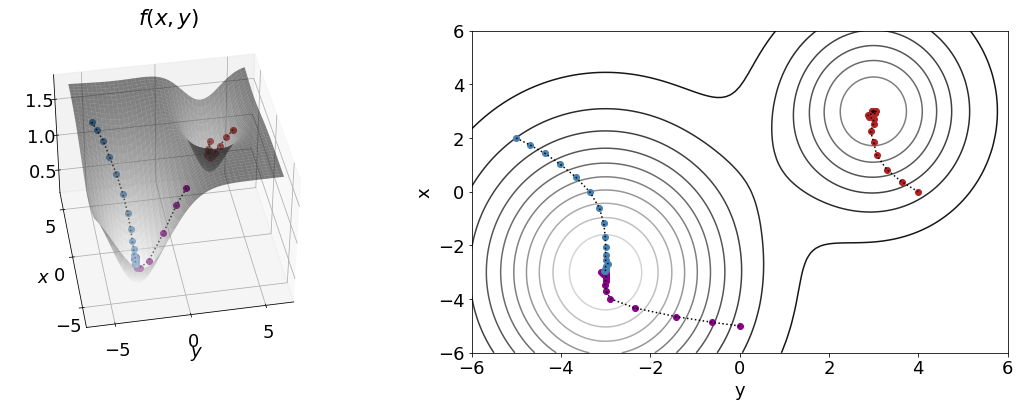

In [5]:
# Starting points
p0s = [
    (4, 0),
    (0, -5),
    (-5, 2)
]
# Trail
ps = []
fs = []

maxiter = 100
batch = 20
τ = 2
ϵ = 5e-4
for p0 in p0s:
    x = np.empty(maxiter + 1)
    y = np.empty(maxiter + 1)
    f = np.empty(maxiter + 1)

    x[0], y[0] = p0
    f[0], dfx, dfy = stochastic_eval(X, Y, F, dFx, dFy, *p0, batch=batch)

    for i in range(maxiter):
        # update x, y, and f
        x[i+1] = x[i] - τ * dfx
        y[i+1] = y[i] - τ * dfy
        f[i+1], dfx, dfy = stochastic_eval(X, Y, F, dFx, dFy, x[i+1], y[i+1], batch=batch)

        # check convergence
        if abs(f[i+1] - f[i]) < ϵ:
            ps.append((x[:i+2], y[:i+2]))
            fs.append(f[:i+2])
            break
    else:
        ps.append((x, y))
        fs.append(f)

# Figure 6.11
plot_optimization(X, Y, F, ps, fs, colors=['firebrick', 'darkmagenta', 'steelblue'])